In [38]:
from elasticsearch import Elasticsearch, exceptions as es_exceptions
from elasticsearch.helpers import scan
es = Elasticsearch([{'host':'uct2-es-door.mwt2.org', 'port':9200}])

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

In [39]:
ind="stashcp-2016.7"

myquery1={
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "*",
          "analyze_wildcard": True
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "query": {
                "query_string": {
                  "analyze_wildcard": True,
                  "query": "*"
                }
              }
            },
            {
              "range": {
                "timestamp": {
                  "gte": 1467383312083,
                  "lte": 1467387756827,
                  "format": "epoch_millis"
                }
              }
            }
          ],
        }
      }
    }
  },
}
myquery2={
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "*",
          "analyze_wildcard": True
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "query": {
                "query_string": {
                  "analyze_wildcard": True,
                  "query": "*"
                }
              }
            },
            {
              "range": {
                "timestamp": {
                  "gte": 1467396471541,
                  "lte": 1467399379488,
                  "format": "epoch_millis"
                }
              }
            }
          ],
        }
      }
    }
  },
}

In [40]:
page= es.search(index=ind, body=myquery2, scroll='2m', search_type='scan', size=1)

sid = page['_scroll_id']

scroll_size = page['hits']['total']
results=[]

while (scroll_size > 0):
    page = es.scroll(scroll_id = sid, scroll = '2m')
    results.append(page['hits']['hits'])
    sid = page['_scroll_id']
    scroll_size = len(page['hits']['hits'])

scroll_size = page['hits']['total']
Res=[]
for i in range(0,scroll_size):
    Res.append(results[i][0]['_source'])
    
print(scroll_size)

df = pd.DataFrame(Res)
#print(df.head(2))

del df['destination_space']
del df['xrdcp_version']
del df['tries']
del df['download_size']
del df['filesize']
del df['IP']
del df['xrdcp_exit']

begin=[]
for i in range(scroll_size):
    begin.append((int(df['timestamp'][i])-int(df['download_time'][i]))) #convert to minutes
    
df['begin']=begin
print(df.head(2))
print(list(df.columns.values))

974
  download_time                           filename  \
0         60122  user/taburaad/public/2gb_file.tar   
1         60128  user/taburaad/public/2gb_file.tar   

                         host       sitename   status      timestamp  \
0    root://hcc-stash.unl.edu  Sandhills-CE1  Success  1467396563000   
1  root://data.ci-connect.net       NUMEP_CE  Success  1467396563000   

           begin  
0  1467396502878  
1  1467396502872  
['download_time', 'filename', 'host', 'sitename', 'status', 'timestamp', 'begin']


In [47]:
def plot_jobs(site, name):
    columns=list(df.columns.values)
    df_site=pd.DataFrame(columns=columns)
    for i in range(scroll_size):
        if df['host'][i]==site:
            df_site=df_site.append(df.iloc[[i]])
    length=df_site.shape[0]
    df_site['trunk']=0
    df_site['timeout']=0
    for i in range(length):
        begin=int(df_site['begin'].iloc[i])//1000
        end=int(df_site['timestamp'].iloc[i])//1000
        df_site['begin'].iloc[i]=datetime.datetime.fromtimestamp(begin).strftime('%Y-%m-%d %H:%M:%S')
        df_site['timestamp'].iloc[i]=datetime.datetime.fromtimestamp(end).strftime('%Y-%m-%d %H:%M:%S')
        if df_site['status'].iloc[i]=='Trunk Success':
            df_site['trunk'].iloc[i]=1
        if df_site['status'].iloc[i]=='Timeout':
            df_site['timeout'].iloc[i]=1 
    
    df_site=df_site.set_index(['timestamp'])    
    df_site.index = pd.to_datetime(df_site.index, unit='s')
    df_site['begin']=pd.to_datetime(df_site.begin, unit='s')

    jobs = pd.concat([pd.Series(1, df_site.begin), pd.Series(-1, df_site.index)]).resample('1Min', how='sum').cumsum()
    trunk=df_site.trunk.resample('1Min',how='sum')
    timeout=df_site.timeout.resample('1Min',how='sum')

    plt.figure(figsize=[18, 8]) 
    plt.title('Concurrent jobs vs. completion status of ' + site)
    #plt.xlabel('Time', fontsize=18)
    #plt.ylabel('xlabel', fontsize=18)
    jobs.plot(label="# Jobs", legend=True).set_ylabel('# jobs running', color='b',fontsize=18)
    trunk.plot(secondary_y=True, label="# Jobs ending at origin", legend=True).set_ylabel('# jobs ending', color='k',fontsize=18)
    timeout.plot(secondary_y=True, label="# Jobs Timeout", legend=True).set_xlabel('Time', color='k',fontsize=18)
    plt.savefig(name+'.png')
    plt.show()


/home/ivukotic/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/ivukotic/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
/home/ivukotic/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
/home/ivukotic/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()


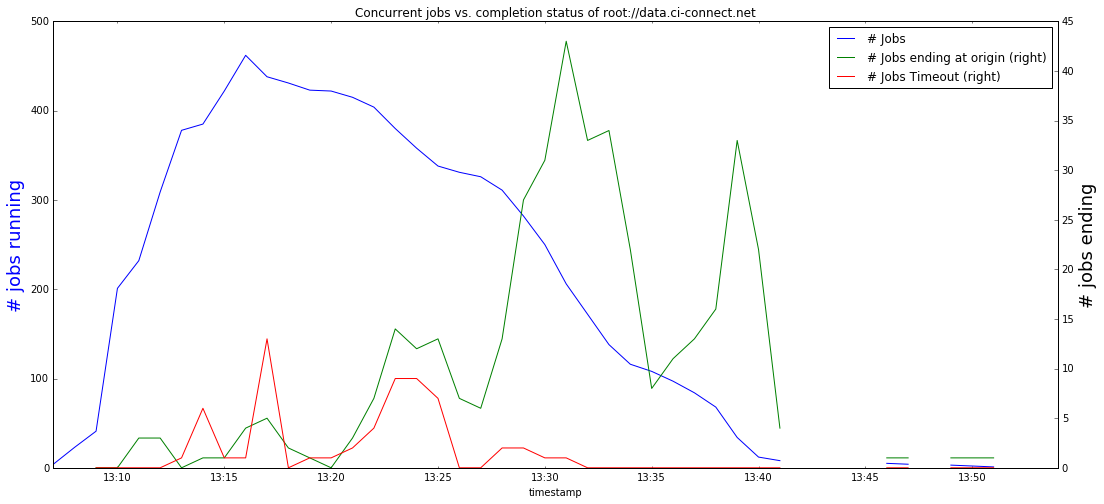

In [48]:
plot_jobs('root://data.ci-connect.net','origin2')
#plot_jobs('root://xrd-cache-1.t2.ucsd.edu','ucsd2')
#plot_jobs('root://hcc-stash.unl.edu','unl2')
#plot_jobs('root://mwt2-stashcache.campuscluster.illinois.edu','mwt2_2')
#plot_jobs('root://osgxroot.usatlas.bnl.gov','usatlas2')